In [16]:
import cv2 as cv
import os
import tensorrt as trt
import logging as logger
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import matplotlib.pyplot as plt

In [17]:
trt.__version__

'10.6.0'

In [18]:
def load_trt_engine(engine_path):
        '''
        Load TRT engine
        '''
        TRT_LOGGER = trt.Logger(trt.Logger.INFO)
        if not os.path.exists(engine_path):
            logger.error(f"Engine file not found at {engine_path}")
            return None
        
        with open(engine_path, 'rb') as f, trt.Runtime(TRT_LOGGER) as runtime:
            try:
                engine = runtime.deserialize_cuda_engine(f.read())
                if engine is None:
                    script_dir = os.path.dirname(os.path.realpath(__file__))
                    logger.error(f"Failed to load engine from {script_dir}")
                return engine
            except Exception as e:
                logger.error(f"Exception while loading engine: {e}")
                return None
    
def get_intrinsics(file_path):
    # Open the file storage for reading
    cv_file = cv.FileStorage(file_path, cv.FILE_STORAGE_READ)

    intrinsics = {}
    # Read the left stereo map (x coordinates)
    intrinsics['Left_Stereo_Map_x'] = cv_file.getNode("Left_Stereo_Map_x").mat()

    # Read the left stereo map (y coordinates)
    intrinsics['Left_Stereo_Map_y'] = cv_file.getNode("Left_Stereo_Map_y").mat()

    # Read the right stereo map (x coordinates)
    intrinsics['Right_Stereo_Map_x'] = cv_file.getNode("Right_Stereo_Map_x").mat()

    # Read the right stereo map (y coordinates)
    intrinsics['Right_Stereo_Map_y'] = cv_file.getNode("Right_Stereo_Map_y").mat()

    # Read the rectified camera matrix
    intrinsics['Rectifyed_mat_left'] = cv_file.getNode("Rectifyed_mat_left").mat()
    intrinsics['Mat_left'] = cv_file.getNode("Mat_left").mat()

    # Read the baseline (distance between the two cameras)
    intrinsics['Baseline'] = cv_file.getNode("Baseline").real()

    return intrinsics

In [19]:
engine = load_trt_engine('/rosslam/model_converter/model_480.engine')
if engine is None:
    logger.error("Failed to load TensorRT engine.")


execution_context = engine.create_execution_context()
if execution_context is None:
    logger.error("Failed to create TensorRT execution context.")
intrinsics = get_intrinsics('/var/camera_params/intrinsics.xml')

[11/11/2024-17:48:07] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[11/11/2024-17:48:07] [TRT] [I] Loaded engine size: 14 MiB
[11/11/2024-17:48:07] [TRT] [I] [MS] Running engine with multi stream info
[11/11/2024-17:48:07] [TRT] [I] [MS] Number of aux streams is 3
[11/11/2024-17:48:07] [TRT] [I] [MS] Number of total worker streams is 4
[11/11/2024-17:48:07] [TRT] [I] [MS] The main stream provided by execute/enqueue calls is the first worker stream
[11/11/2024-17:48:07] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +570, now: CPU 1, GPU 1242 (MiB)


In [20]:
# Inspect the inputs of the TensorRT engine
def inspect_inputs(engine):
    for binding in engine:
        if engine.binding_is_input(binding):
            input_shape = engine.get_binding_shape(binding)
            input_dtype = engine.get_binding_dtype(binding)
            print(f"Input Name: {binding}")
            print(f"Input Shape: {input_shape}")
            print(f"Input Data Type: {input_dtype}\n")

In [21]:
input_tensor_name = engine.get_tensor_name(0)  # Input tensor name
output_tensor_name = engine.get_tensor_name(1)  # Output tensor name
print(f"Input tensor: {input_tensor_name}")
print(f"Output tensor: {output_tensor_name}")

Input tensor: input
Output tensor: reference_output_disparity


In [22]:
input_tensor_shape = engine.get_tensor_shape(input_tensor_name)
output_tensor_shape = engine.get_tensor_shape(output_tensor_name)
print(f"Expected input shape: {input_tensor_shape}")
print(f"Expected output shape: {output_tensor_shape}")


Expected input shape: (1, 6, 480, 640)
Expected output shape: (1, 480, 640, 1)


In [23]:
trt.LayerInformationFormat

tensorrt_bindings.tensorrt.LayerInformationFormat

In [24]:
doebalus = engine.create_engine_inspector()
doebalus.get_engine_information(trt.LayerInformationFormat.JSON)

[11/11/2024-17:48:09] [TRT] [I] The profiling verbosity was set to ProfilingVerbosity::kLAYER_NAMES_ONLY when the engine was built, so only the layer names will be returned. Rebuild the engine with ProfilingVerbosity::kDETAILED to get more verbose layer information.


'{"Layers": ["Reformatting CopyNode for Input Tensor 0 to PWN(mul/x + ONNXTRT_Broadcast + mul, PWN(const_fold_opt__1387, PWN(sub)))"\n,"PWN(mul/x + ONNXTRT_Broadcast + mul, PWN(const_fold_opt__1387, PWN(sub)))"\n,"Reformatting CopyNode for Output Tensor 0 to PWN(mul/x + ONNXTRT_Broadcast + mul, PWN(const_fold_opt__1387, PWN(sub)))"\n,"hitnet_single_frame/strided_slice_1"\n,"hitnet_single_frame/strided_slice"\n,"fe_shared/conv_down_1_0/BiasAdd;level0_1/shared/prop0/prop/resblock1/conv2/Conv2D;fe_shared/conv_down_1_0/Conv2D;fe_shared/conv_down_1_0/bias1"\n,"PWN(fe_shared/LeakyRelu)"\n,"fe_shared/conv_down_0/BiasAdd;fe_shared/conv_up_2_1/Conv2D;fe_shared/conv_down_0/Conv2D;fe_shared/conv_down_0/bias1"\n,"PWN(fe_shared/LeakyRelu_1)"\n,"fe_shared/conv_down_1_1/BiasAdd;fe_shared/conv_up_2_1/Conv2D;fe_shared/conv_down_1_1/Conv2D;fe_shared/conv_down_1_1/bias1"\n,"PWN(fe_shared/LeakyRelu_2)"\n,"fe_shared/conv_down_1/BiasAdd;fe_shared/conv_up_2_2/Conv2D;fe_shared/conv_down_1/Conv2D;fe_shared/con

In [25]:
# for i in range(engine.num_layers):
#     layer = engine.get_layer(i)
#     print(f"Layer {i}:")
#     print(f"    Name: {layer.name}")
#     print(f"    Type: {layer.type}")
#     for j in range(layer.num_outputs):
#         output_shape = layer.get_output(j).shape
#         print(f"    Output {j} shape: {output_shape}")


In [26]:
for i in range(engine.num_bindings):
    is_input = engine.binding_is_input(i)
    binding_name = engine.get_binding_name(i)
    binding_shape = engine.get_binding_shape(i)
    binding_dtype = engine.get_binding_dtype(i)
    
    print(f"{'Input' if is_input else 'Output'} Binding {i}:")
    print(f"    Name: {binding_name}")
    print(f"    Shape: {binding_shape}")
    print(f"    Data Type: {binding_dtype}")


AttributeError: 'tensorrt_bindings.tensorrt.ICudaEngine' object has no attribute 'num_bindings'

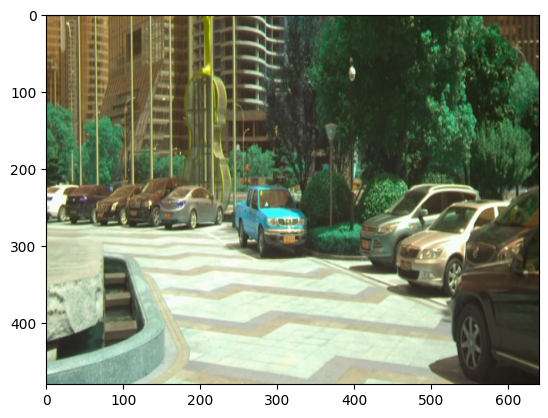

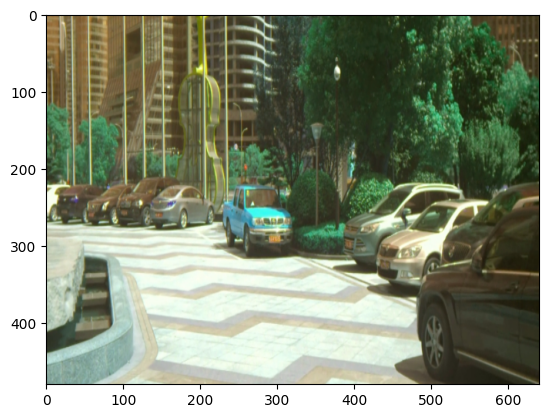

In [ ]:

left_dir = 'test_depth_data/left_small'
right_dir = 'test_depth_data/right_small'

left_images = sorted(os.listdir(left_dir))[0]
right_images = sorted(os.listdir(right_dir))[0]

target_height, target_width = engine.get_tensor_shape(
            engine.get_tensor_name(0))[2], engine.get_tensor_shape(
                engine.get_tensor_name(0))[3]

# for left_img, right_img in zip(left_images, right_images):
# Load images
left_image_path = os.path.join(left_dir, left_images)
right_image_path = os.path.join(right_dir, right_images)


left_image = cv.imread(left_image_path)
right_image = cv.imread(right_image_path)

left_img_res = cv.resize(left_image, (target_width, target_height))
right_img_res = cv.resize(right_image, (target_width, target_height))

plt.imshow(left_img_res)
plt.figure()
plt.imshow(right_img_res)

# Convert to CHW format for TRT and ensure they are contiguous
left_img_chw = left_img_res.transpose((2, 0, 1)).astype('float32')
right_img_chw = right_img_res.transpose((2, 0, 1)).astype('float32')

    # Concatenate along the channel axis to create a 6-channel input
input_tensor = np.concatenate([left_img_chw, right_img_chw], axis=0)

input_tensor = np.ascontiguousarray(np.array([left_img_chw, right_img_chw]), dtype=np.float32)
input_tensor = np.expand_dims(input_tensor, axis=0)
output = np.empty((1, target_height, target_width, 1), dtype=np.float32)
output_1 = np.empty((1, target_height, target_width, 1), dtype=np.float32)
d_input = cuda.mem_alloc(input_tensor.nbytes)
d_output = cuda.mem_alloc(output.nbytes)
d_output_1 = cuda.mem_alloc(output.nbytes)

execution_context.set_tensor_address(engine.get_tensor_name(0), int(d_input)) # input buffer
execution_context.set_tensor_address(engine.get_tensor_name(1), int(d_output)) # output buffer
execution_context.set_tensor_address(engine.get_tensor_name(2), int(d_output_1)) # output buffer

stream = cuda.Stream()
# Copy images to the GPU
cuda.memcpy_htod_async(d_input, input_tensor, stream)

success = execution_context.execute_async_v3(stream_handle=stream.handle)

# Copy result from GPU
cuda.memcpy_dtoh_async(output, d_output, stream)
cuda.memcpy_dtoh_async(output_1, d_output_1, stream)
stream.synchronize()
output = np.squeeze(output, axis=(0, 3))  # Shape: [480, 640]
output_1 = np.squeeze(output_1, axis=(0, 3))  # Shape: [480, 640]


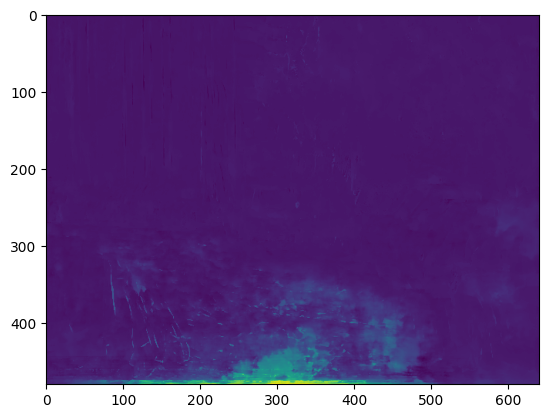

In [ ]:
plt.imshow((output_1 + output))

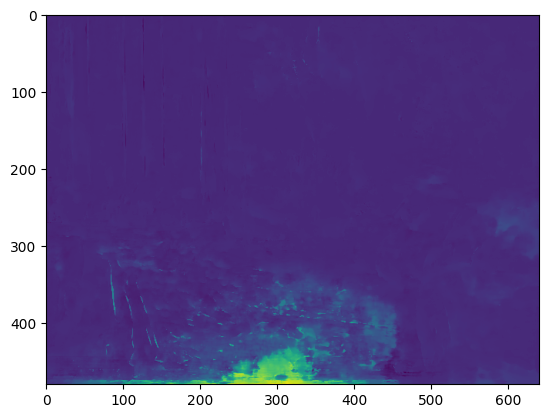

In [ ]:
plt.imshow(output_1)